In [200]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

In [201]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [202]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [306]:
directory = '../data/'
df_empresas = pd.read_csv(directory + "grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2019-2020..csv", sep=";", encoding="ISO-8859-1")
df_empresas["normalised_date"]= pd.to_datetime(df_empresas["normalised_date"]) 
df_empresas = df_empresas.rename(columns={"sentiment": "sentiment_empresas"})

df = pd.read_csv(directory + "stocks_and_sentiment_2020.csv", sep=";", names=['date','sentiment','price'], encoding="ISO-8859-1")
df["date"]= pd.to_datetime(df["date"]) 
df = df.rename(columns={"sentiment": "sentiment_asoc"})

df = df_empresas.merge(df, left_on="normalised_date", right_on="date")
df = df[["sentiment_empresas", "sentiment_asoc", "price"]]
df.head()

,sentiment_empresas,sentiment_asoc,price
0,0.243997,0.219692,-0.169729
1,0.185506,0.214739,0.262752
2,0.130081,0.247731,0.298582
3,0.141136,0.232923,0.320586
4,0.156070,0.284574,0.642212


In [349]:

df_diff = df.copy()
#df_diff["sentiment_diff"] = df["sentiment"].diff()
df_diff = df_diff.dropna()
#df_diff = df_diff[["sentiment_diff", "price"]]


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

#X = scaler.fit_transform(df_diff.values)
#X_sent_asoc = X[:,0][:-future_steps]
#X_prices = X[:,1][:-future_steps]
#X_prices_next = X[:,1]


#plt.plot(X)

X_sent_asoc = df_diff.sentiment_asoc.values[:-future_steps]
X_sent_empresas = df_diff.sentiment_empresas.values[:-future_steps]
X_prices = df_diff.price.values[:-future_steps]
X_prices_next = df_diff.price.values
    
num_steps = 7
future_steps = 1


X = np.array(create_window_data_arrays((X_sent_asoc,X_sent_empresas, X_prices), num_steps))
Y = create_window_data_array_with_shift(X_prices_next, future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(73, 7, 3) (73, 1)


In [356]:
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, random_state=1000)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(65, 7, 3) (65, 1) (8, 7, 3) (8, 1)


Train on 65 samples, validate on 8 samples
Epoch 1/200
 - 0s - loss: 1.4267 - accuracy: 0.0000e+00 - val_loss: 1.1514 - val_accuracy: 0.0000e+00
Epoch 2/200
 - 0s - loss: 1.4525 - accuracy: 0.0000e+00 - val_loss: 1.1545 - val_accuracy: 0.0000e+00
Epoch 3/200
 - 0s - loss: 1.4907 - accuracy: 0.0000e+00 - val_loss: 1.1574 - val_accuracy: 0.0000e+00
Epoch 4/200
 - 0s - loss: 1.4062 - accuracy: 0.0000e+00 - val_loss: 1.1587 - val_accuracy: 0.0000e+00
Epoch 5/200
 - 0s - loss: 1.4607 - accuracy: 0.0000e+00 - val_loss: 1.1594 - val_accuracy: 0.0000e+00
Epoch 6/200
 - 0s - loss: 1.4484 - accuracy: 0.0000e+00 - val_loss: 1.1608 - val_accuracy: 0.0000e+00
Epoch 7/200
 - 0s - loss: 1.4360 - accuracy: 0.0000e+00 - val_loss: 1.1616 - val_accuracy: 0.0000e+00
Epoch 8/200
 - 0s - loss: 1.4347 - accuracy: 0.0000e+00 - val_loss: 1.1623 - val_accuracy: 0.0000e+00
Epoch 9/200
 - 0s - loss: 1.4152 - accuracy: 0.0000e+00 - val_loss: 1.1631 - val_accuracy: 0.0000e+00
Epoch 10/200
 - 0s - loss: 1.4060 - acc

Epoch 81/200
 - 0s - loss: 1.3276 - accuracy: 0.0000e+00 - val_loss: 1.1697 - val_accuracy: 0.0000e+00
Epoch 82/200
 - 0s - loss: 1.3887 - accuracy: 0.0000e+00 - val_loss: 1.1717 - val_accuracy: 0.0000e+00
Epoch 83/200
 - 0s - loss: 1.3895 - accuracy: 0.0000e+00 - val_loss: 1.1694 - val_accuracy: 0.0000e+00
Epoch 84/200
 - 0s - loss: 1.3960 - accuracy: 0.0000e+00 - val_loss: 1.1651 - val_accuracy: 0.0000e+00
Epoch 85/200
 - 0s - loss: 1.3609 - accuracy: 0.0000e+00 - val_loss: 1.1578 - val_accuracy: 0.0000e+00
Epoch 86/200
 - 0s - loss: 1.3777 - accuracy: 0.0000e+00 - val_loss: 1.1474 - val_accuracy: 0.0000e+00
Epoch 87/200
 - 0s - loss: 1.3709 - accuracy: 0.0000e+00 - val_loss: 1.1344 - val_accuracy: 0.0000e+00
Epoch 88/200
 - 0s - loss: 1.3958 - accuracy: 0.0000e+00 - val_loss: 1.1215 - val_accuracy: 0.0000e+00
Epoch 89/200
 - 0s - loss: 1.4003 - accuracy: 0.0000e+00 - val_loss: 1.1152 - val_accuracy: 0.0000e+00
Epoch 90/200
 - 0s - loss: 1.3623 - accuracy: 0.0000e+00 - val_loss: 1.11

Epoch 160/200
 - 0s - loss: 1.3833 - accuracy: 0.0000e+00 - val_loss: 1.2108 - val_accuracy: 0.0000e+00
Epoch 161/200
 - 0s - loss: 1.2919 - accuracy: 0.0000e+00 - val_loss: 1.1993 - val_accuracy: 0.0000e+00
Epoch 162/200
 - 0s - loss: 1.2953 - accuracy: 0.0000e+00 - val_loss: 1.1759 - val_accuracy: 0.0000e+00
Epoch 163/200
 - 0s - loss: 1.2388 - accuracy: 0.0000e+00 - val_loss: 1.1601 - val_accuracy: 0.0000e+00
Epoch 164/200
 - 0s - loss: 1.3376 - accuracy: 0.0000e+00 - val_loss: 1.1656 - val_accuracy: 0.0000e+00
Epoch 165/200
 - 0s - loss: 1.3256 - accuracy: 0.0000e+00 - val_loss: 1.1431 - val_accuracy: 0.0000e+00
Epoch 166/200
 - 0s - loss: 1.3884 - accuracy: 0.0000e+00 - val_loss: 1.1392 - val_accuracy: 0.0000e+00
Epoch 167/200
 - 0s - loss: 1.2554 - accuracy: 0.0000e+00 - val_loss: 1.1518 - val_accuracy: 0.0000e+00
Epoch 168/200
 - 0s - loss: 1.1752 - accuracy: 0.0000e+00 - val_loss: 1.1694 - val_accuracy: 0.0000e+00
Epoch 169/200
 - 0s - loss: 1.2896 - accuracy: 0.0000e+00 - val_

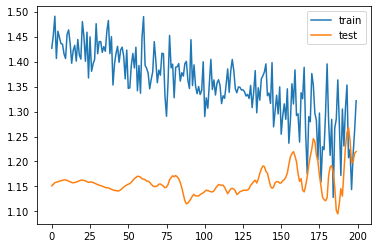

In [357]:
output_size = future_steps
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.8))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 58 samples, validate on 15 samples
Epoch 1/300
 - 0s - loss: 1.4677 - accuracy: 0.0000e+00 - mae: 1.4677 - val_loss: 1.3256 - val_accuracy: 0.0000e+00 - val_mae: 1.3256
Epoch 2/300
 - 0s - loss: 1.5407 - accuracy: 0.0000e+00 - mae: 1.5407 - val_loss: 1.3321 - val_accuracy: 0.0000e+00 - val_mae: 1.3321
Epoch 3/300
 - 0s - loss: 1.4154 - accuracy: 0.0000e+00 - mae: 1.4154 - val_loss: 1.3644 - val_accuracy: 0.0000e+00 - val_mae: 1.3644
Epoch 4/300
 - 0s - loss: 1.4545 - accuracy: 0.0000e+00 - mae: 1.4545 - val_loss: 1.3821 - val_accuracy: 0.0000e+00 - val_mae: 1.3821
Epoch 5/300
 - 0s - loss: 1.4788 - accuracy: 0.0000e+00 - mae: 1.4788 - val_loss: 1.3883 - val_accuracy: 0.0000e+00 - val_mae: 1.3883
Epoch 6/300
 - 0s - loss: 1.4612 - accuracy: 0.0000e+00 - mae: 1.4612 - val_loss: 1.3949 - val_accuracy: 0.0000e+00 - val_mae: 1.3949
Epoch 7/300
 - 0s - loss: 1.3431 - accuracy: 0.0000e+00 - mae: 1.3431 - val_loss: 1.4000 - val_accuracy: 0.0000e+00 - val_mae: 1.4000
Epoch 8/300
 - 0s 

Epoch 62/300
 - 0s - loss: 1.1392 - accuracy: 0.0000e+00 - mae: 1.1392 - val_loss: 1.4007 - val_accuracy: 0.0000e+00 - val_mae: 1.4007
Epoch 63/300
 - 0s - loss: 1.2511 - accuracy: 0.0000e+00 - mae: 1.2511 - val_loss: 1.3994 - val_accuracy: 0.0000e+00 - val_mae: 1.3994
Epoch 64/300
 - 0s - loss: 1.2934 - accuracy: 0.0000e+00 - mae: 1.2934 - val_loss: 1.3987 - val_accuracy: 0.0000e+00 - val_mae: 1.3987
Epoch 65/300
 - 0s - loss: 1.2851 - accuracy: 0.0000e+00 - mae: 1.2851 - val_loss: 1.3938 - val_accuracy: 0.0000e+00 - val_mae: 1.3938
Epoch 66/300
 - 0s - loss: 1.2085 - accuracy: 0.0000e+00 - mae: 1.2085 - val_loss: 1.3980 - val_accuracy: 0.0000e+00 - val_mae: 1.3980
Epoch 67/300
 - 0s - loss: 1.2680 - accuracy: 0.0000e+00 - mae: 1.2680 - val_loss: 1.3994 - val_accuracy: 0.0000e+00 - val_mae: 1.3994
Epoch 68/300
 - 0s - loss: 1.3134 - accuracy: 0.0000e+00 - mae: 1.3134 - val_loss: 1.4005 - val_accuracy: 0.0000e+00 - val_mae: 1.4005
Epoch 69/300
 - 0s - loss: 1.2194 - accuracy: 0.0000e+0

Epoch 123/300
 - 0s - loss: 1.1378 - accuracy: 0.0000e+00 - mae: 1.1378 - val_loss: 1.4763 - val_accuracy: 0.0000e+00 - val_mae: 1.4763
Epoch 124/300
 - 0s - loss: 1.1625 - accuracy: 0.0000e+00 - mae: 1.1625 - val_loss: 1.4778 - val_accuracy: 0.0000e+00 - val_mae: 1.4778
Epoch 125/300
 - 0s - loss: 1.1750 - accuracy: 0.0000e+00 - mae: 1.1750 - val_loss: 1.4732 - val_accuracy: 0.0000e+00 - val_mae: 1.4732
Epoch 126/300
 - 0s - loss: 1.1884 - accuracy: 0.0000e+00 - mae: 1.1884 - val_loss: 1.4701 - val_accuracy: 0.0000e+00 - val_mae: 1.4701
Epoch 127/300
 - 0s - loss: 1.2403 - accuracy: 0.0000e+00 - mae: 1.2403 - val_loss: 1.4742 - val_accuracy: 0.0000e+00 - val_mae: 1.4742
Epoch 128/300
 - 0s - loss: 1.1669 - accuracy: 0.0000e+00 - mae: 1.1669 - val_loss: 1.4759 - val_accuracy: 0.0000e+00 - val_mae: 1.4759
Epoch 129/300
 - 0s - loss: 1.1794 - accuracy: 0.0000e+00 - mae: 1.1794 - val_loss: 1.4785 - val_accuracy: 0.0000e+00 - val_mae: 1.4785
Epoch 130/300
 - 0s - loss: 1.1690 - accuracy: 0

Epoch 184/300
 - 0s - loss: 1.0849 - accuracy: 0.0000e+00 - mae: 1.0849 - val_loss: 1.5217 - val_accuracy: 0.0000e+00 - val_mae: 1.5217
Epoch 185/300
 - 0s - loss: 1.0517 - accuracy: 0.0000e+00 - mae: 1.0517 - val_loss: 1.5316 - val_accuracy: 0.0000e+00 - val_mae: 1.5316
Epoch 186/300
 - 0s - loss: 1.1520 - accuracy: 0.0000e+00 - mae: 1.1520 - val_loss: 1.5346 - val_accuracy: 0.0000e+00 - val_mae: 1.5346
Epoch 187/300
 - 0s - loss: 1.2880 - accuracy: 0.0000e+00 - mae: 1.2880 - val_loss: 1.5201 - val_accuracy: 0.0000e+00 - val_mae: 1.5201
Epoch 188/300
 - 0s - loss: 1.0574 - accuracy: 0.0000e+00 - mae: 1.0574 - val_loss: 1.5172 - val_accuracy: 0.0000e+00 - val_mae: 1.5172
Epoch 189/300
 - 0s - loss: 1.2303 - accuracy: 0.0000e+00 - mae: 1.2303 - val_loss: 1.5161 - val_accuracy: 0.0000e+00 - val_mae: 1.5161
Epoch 190/300
 - 0s - loss: 1.1460 - accuracy: 0.0000e+00 - mae: 1.1460 - val_loss: 1.5228 - val_accuracy: 0.0000e+00 - val_mae: 1.5228
Epoch 191/300
 - 0s - loss: 1.0107 - accuracy: 0

Epoch 245/300
 - 0s - loss: 1.1209 - accuracy: 0.0000e+00 - mae: 1.1209 - val_loss: 1.5475 - val_accuracy: 0.0000e+00 - val_mae: 1.5475
Epoch 246/300
 - 0s - loss: 1.0743 - accuracy: 0.0000e+00 - mae: 1.0743 - val_loss: 1.5587 - val_accuracy: 0.0000e+00 - val_mae: 1.5587
Epoch 247/300
 - 0s - loss: 1.0295 - accuracy: 0.0000e+00 - mae: 1.0295 - val_loss: 1.5738 - val_accuracy: 0.0000e+00 - val_mae: 1.5738
Epoch 248/300
 - 0s - loss: 1.0473 - accuracy: 0.0000e+00 - mae: 1.0473 - val_loss: 1.5651 - val_accuracy: 0.0000e+00 - val_mae: 1.5651
Epoch 249/300
 - 0s - loss: 1.0704 - accuracy: 0.0000e+00 - mae: 1.0704 - val_loss: 1.5442 - val_accuracy: 0.0000e+00 - val_mae: 1.5442
Epoch 250/300
 - 0s - loss: 1.0981 - accuracy: 0.0000e+00 - mae: 1.0981 - val_loss: 1.5358 - val_accuracy: 0.0000e+00 - val_mae: 1.5358
Epoch 251/300
 - 0s - loss: 1.0388 - accuracy: 0.0000e+00 - mae: 1.0388 - val_loss: 1.5271 - val_accuracy: 0.0000e+00 - val_mae: 1.5271
Epoch 252/300
 - 0s - loss: 1.1419 - accuracy: 0

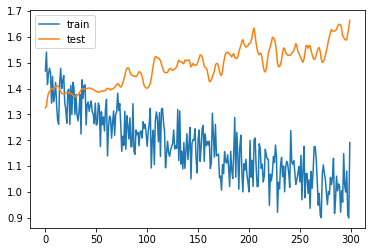

In [353]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [358]:

#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)

print("---")
#print(M_untransformed)

print(df_diff.values[-3:])



8/8 [==============================] - 0s 7ms/step
1.2197979731163602
[[ 0.02122515 -0.4861362 ]
 [ 1.8077442  -0.48997563]
 [ 0.17437786  0.41223526]
 [ 1.78242223  0.0918427 ]
 [-0.32124476 -0.30667049]
 [ 1.34902535 -0.29603684]
 [-1.75366996 -0.07209561]
 [-2.0289736  -0.34531873]]
---
[[ 0.10340447  0.32201187  0.8008812 ]
 [ 0.12953724  0.33362364 -1.04792342]
 [ 0.11742065  0.23765822  1.39561073]]
